In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sympy import *
from scipy.stats import norm

np.set_printoptions(formatter={'float': lambda x: '{:8.2f}'.format(x)})

### 3. Python exercise: Building trees that do real pricing.

In [2]:
# a) 
def BSP(S, K, r, T, sigma):
    d2 = (np.log(S/K)+(r-(sigma**2)/2)*T)/(sigma*np.sqrt(T))
    d1 = d2 + sigma*np.sqrt(T)
    c = norm.cdf(d1)*S - norm.cdf(d2)*K*np.exp(-r*T)
    return c

In [3]:
def printPascal(n): 
    def binomialCoeff(n, k): 
        res = 1
        if (k > n - k): 
            k = n - k 
        for i in range(0 , k) : 
            res = res * (n - i) 
            res = res // (i + 1) 
        return res
    Pascal = []
    for i in range(0, n+1) : 
        Pascal.append(binomialCoeff(n, i))
    return np.array(Pascal)

In [4]:
# b) c) d)
def CRR(S, K, r, T, sigma, n):
    def CallOptionP(S, n, u, d, r, K):
        def StockP(S, n, u, d):
            price = np.zeros(n+1)
            for i in range(n+1):
                price[i] = S*u**(n-i)*d**i
            return price
    
        price_C = np.zeros(n+1)
        q = (1+r-d) / (u-d)
        for i in range(n+1):
            price_C[i] = max(StockP(S, n, u, d)[i]-K, 0)
            price_C[i] = price_C[i]*q**(n-i)*(1-q)**i
        return (np.dot(price_C, printPascal(n)))/(1+r)**n
    
    deltaT = T/n
    u = np.exp(sigma*np.sqrt(deltaT))
    d = np.exp(-sigma*np.sqrt(deltaT))
    rate = np.exp(r*deltaT)-1
    
    return CallOptionP(S, n, u, d, rate, K)

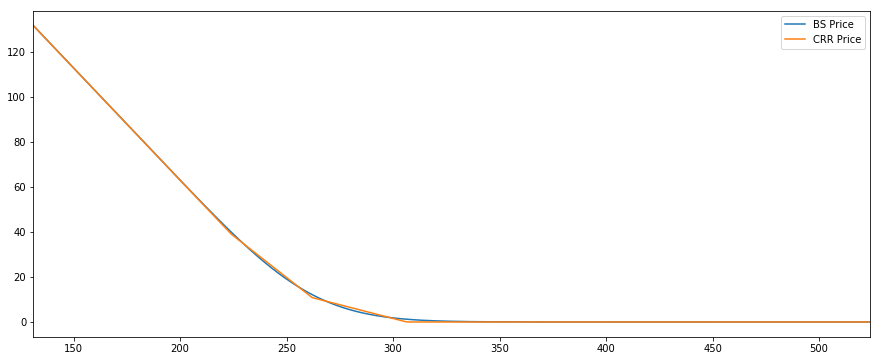

In [5]:
# For n = 2
AAPL_BSP = []
for k in np.arange(262/2, 262*2+1, 1):
    AAPL_BSP.append(BSP(262, k, 0.0178, 1/4, 0.2213))

AAPL_CRR = []
for k in np.arange(262/2, 262*2+1, 1):
    AAPL_CRR.append(CRR(262, k, 0.0178, 1/4, 0.2213, 2))

BSP_CRR = pd.DataFrame({"BS Price": np.array(AAPL_BSP),
                       "CRR Price": np.array(AAPL_CRR), 
                       "Difference": np.array(AAPL_CRR)-np.array(AAPL_BSP)}, 
                       index = list(np.arange(262/2, 262*2+1, 1)))

BSP_CRR.iloc[:, 0:2].plot(figsize = (15, 6))

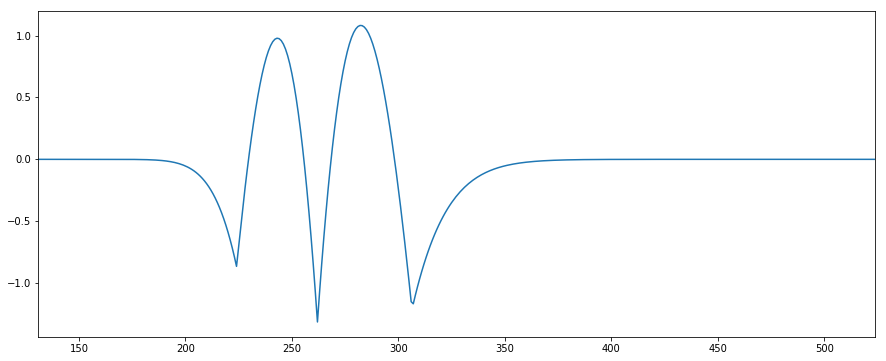

In [6]:
BSP_CRR.iloc[:, 2].plot(figsize = (15, 6))

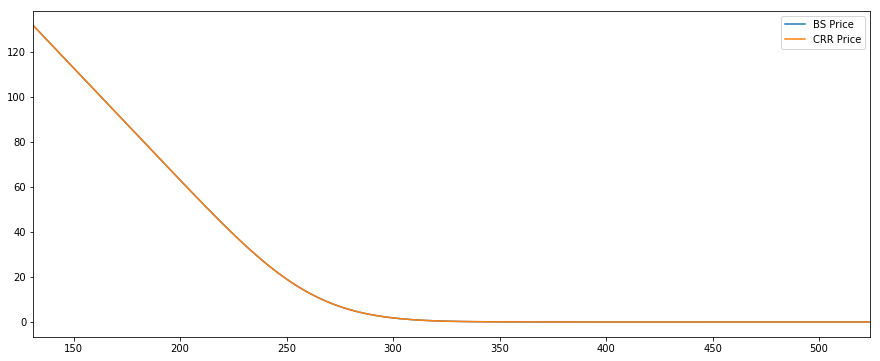

In [7]:
# For n = 300
AAPL_BSP1 = []
for k in np.arange(262/2, 262*2+1, 1):
    AAPL_BSP1.append(BSP(262, k, 0.0178, 1/4, 0.2213))

AAPL_CRR1 = []
for k in np.arange(262/2, 262*2+1, 1):
    AAPL_CRR1.append(CRR(262, k, 0.0178, 1/4, 0.2213, 300))

BSP_CRR1 = pd.DataFrame({"BS Price": np.array(AAPL_BSP1),
                        "CRR Price": np.array(AAPL_CRR1), 
                        "Difference": np.array(AAPL_CRR1)-np.array(AAPL_BSP1)}, 
                       index = list(np.arange(262/2, 262*2+1, 1)))

BSP_CRR1.iloc[:, 0:2].plot(figsize = (15, 6))

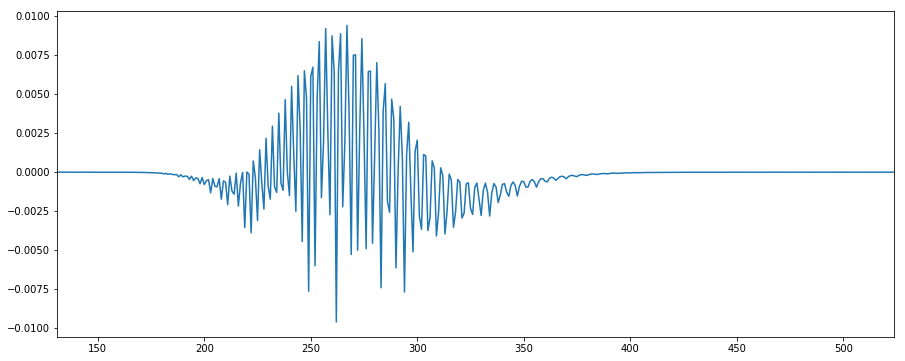

In [8]:
BSP_CRR1.iloc[:, 2].plot(figsize = (15, 6))

### 4. Python exercise: Building trees that price Americans.

In [9]:
# a) b) c) d) e) 
def CRR_A(S, K, r, T, sigma, n, nd, dividend):
    def CallOptionP_A(S, n, u, d, r, K, nd, dividend):
        def StockP_A(S, n, u, d, nd, dividend):
            price_D = np.zeros(nd+1)
            price = np.zeros(n+1)
            for i in range(nd+1):
                price_D[i] = S*u**(nd-i)*d**i*(1-dividend)
            for i in range(n+1):
                price[i] = S*u**(n-i)*d**i*(1-dividend)
            return price_D, price

        price_C = np.zeros((n+1-nd, n+1))
        q = (1+r-d) / (u-d)
        for i in range(n+1):
            price_C[n-nd, i] = max(StockP_A(S, n, u, d, nd, dividend)[1][i]-K, 0)
        for i in sorted(list(range(n-nd)), reverse = True):
            for j in range(n+1):
                if i+nd >= j:
                    price_C[i,j] = (q*price_C[i+1,j]+(1-q)*price_C[i+1,j+1])/(1+r)
                else:
                    price_C[i,j] = 0
        for i in range(nd+1):
            price_C[0, i] = max(max(StockP_A(S, n, u, d, nd, dividend)[0][i]/(1-dividend)-K, 0), price_C[0, i])
            price_C[0, i] = price_C[0, i]*q**(nd-i)*(1-q)**i
        return np.dot(price_C[0][0:nd+1], printPascal(nd))/(1+r)**nd
    
    deltaT = T/n
    u = np.exp(sigma*np.sqrt(deltaT))
    d = np.exp(-sigma*np.sqrt(deltaT))
    rate = np.exp(r*deltaT)-1
    
    return CallOptionP_A(S, n, u, d, rate, K, nd, dividend)

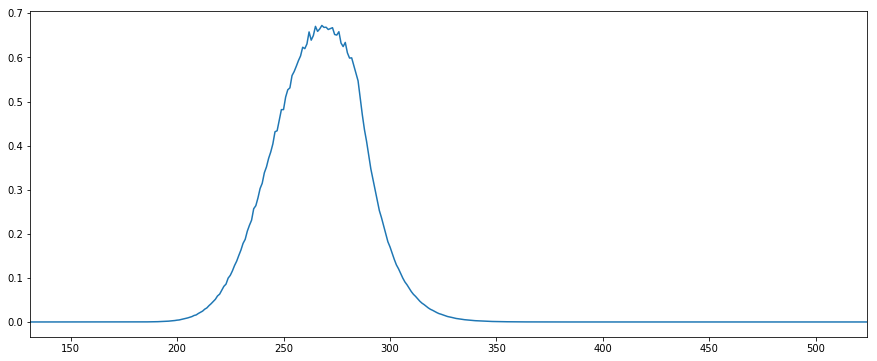

In [11]:
# For n = 300
AAPL_Euro = []
for k in np.arange(262/2, 262*2+1, 1):
    AAPL_Euro.append(max(CRR(262, k, 0.0178, 1/6, 0.2213, 300), CRR(262*(1-0.03), k, 0.0178, 1/4, 0.2213, 300)))

AAPL_Amer = []
for k in np.arange(262/2, 262*2+1, 1):
    AAPL_Amer.append(CRR_A(262, k, 0.0178, 1/4, 0.2213, 300, 200, 0.03))

Amer_Euro = pd.DataFrame({"Euro bound": np.array(AAPL_Euro),
                        "American call": np.array(AAPL_Amer), 
                        "Difference": np.array(AAPL_Amer)-np.array(AAPL_Euro)}, 
                       index = list(np.arange(262/2, 262*2+1, 1)))

Amer_Euro.iloc[:, 2].plot(figsize = (15, 6))